# DM Traitement du SIgnal :Endamne Obiang Merli



###### 2.1   fréquencede Nyquist
la fréquence d'échantillonnage des signaux étantde 100Hz,on a une fréquence de Nyquist $\nu_N$ = 50Hz 


###### 2.2 Representation des séries temporelles 

In [5]:
#Importation des Modules

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal


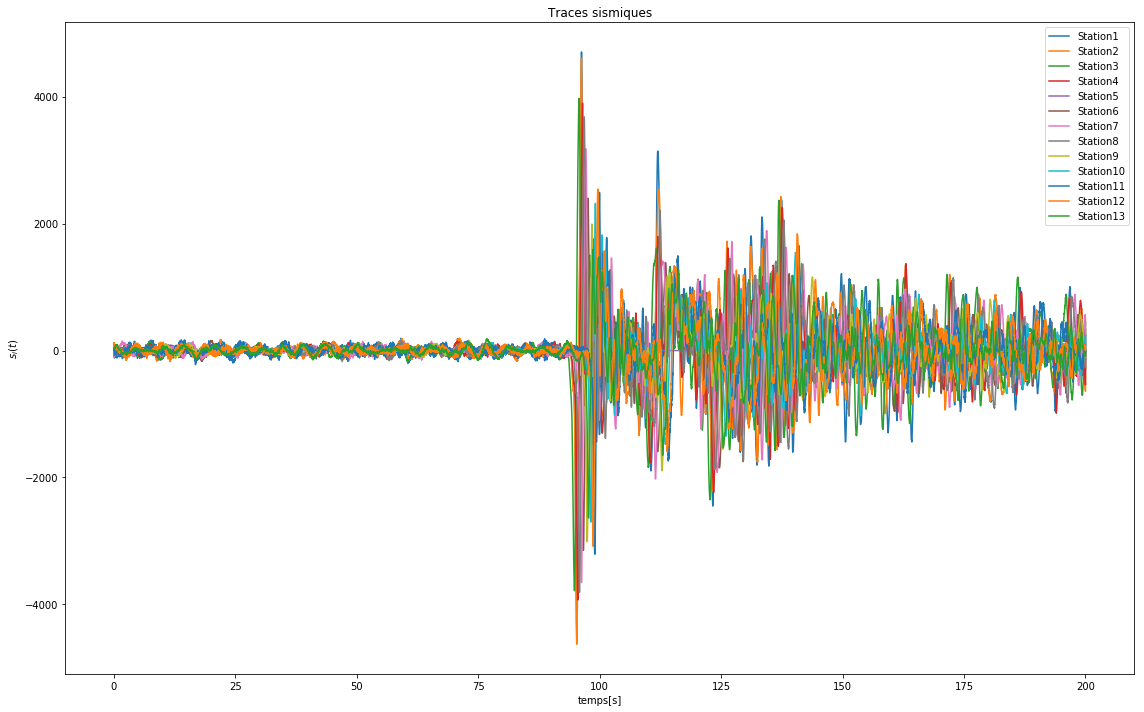

In [6]:
#Representation graphique des séries temporelles

fe = 100                                          #Fréquence d'échantillonnage     
Data = np.loadtxt("event_16.txt")                 #Lecture de l'enregistrement event_16

Max = len(Data)

#Vecteur contenant en chaque position i, le signal de la station i-1
Station = [np.zeros(Max, dtype='float') for i in range(13)]   

Time = np.linspace(0, Max, Max)/fe                 #Vecteur temps


for i in range(13) :
    for j in range(Max) :
        Station[i][j] = Data[j][i]

plt.figure(figsize=(16,10))       
for i in range(13) :
     plt.plot(Time, Station[i], label='Station%d' %(i+1))

        
plt.xlabel("temps[s]")
plt.ylabel(r"$s_i (t)$")
plt.title("Traces sismiques")
plt.tight_layout()
plt.legend()
plt.show()

###### 2.2 Application d'un filtre 

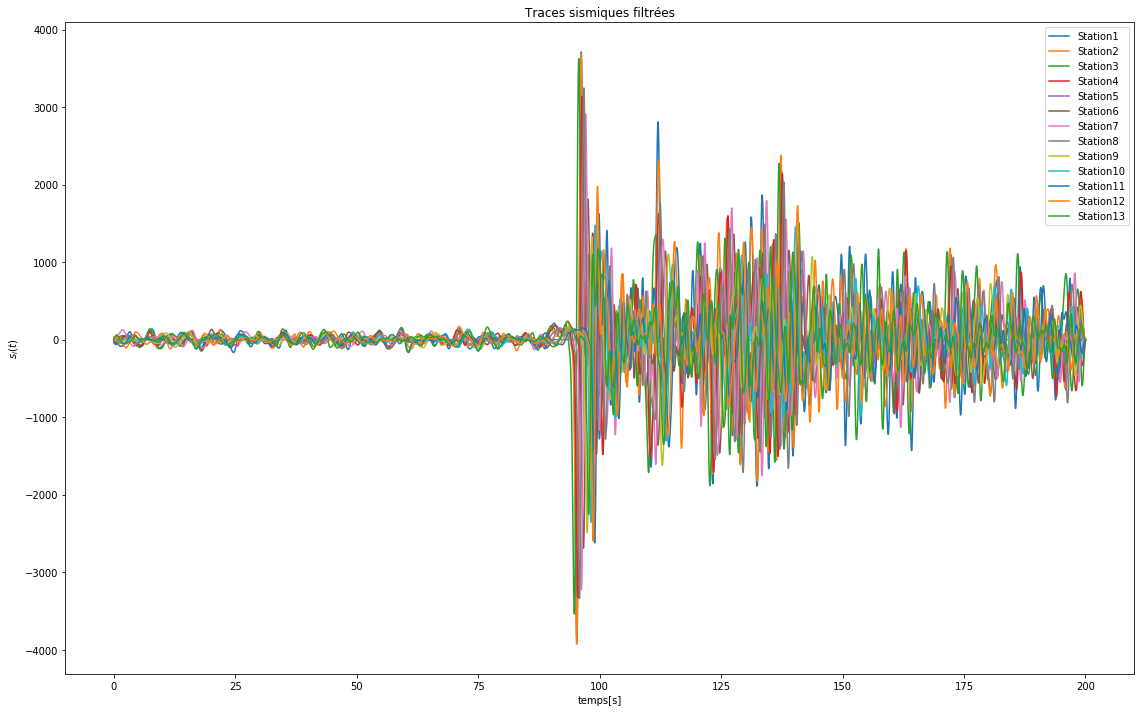

In [7]:
#Apllication du filtre de butterworth


fN = fe/2                                    #Fréquence de Nyquist

Freq1 = 0.1                                  #Fréquence de coupure 1
Freq2 = 1                                    #Fréquence de coupure 2
Wn = np.array([Freq1, Freq2])/fN
n = 3

b, a = signal.butter(n, Wn, btype='bandpass')

#Application du filtre

Station_filt = []

for i in range(13) :
    Station_filt.append(signal.filtfilt(b, a, Station[i]))

    
#Représentation graphique des series temporelles

plt.figure(figsize=(16,10))       
for i in range(13) :
     plt.plot(Time, Station_filt[i], label='Station%d' %(i+1))

plt.xlabel("temps[s]")
plt.ylabel(r"$s_i (t)$")
plt.title("Traces sismiques filtrées")
plt.tight_layout()
plt.legend()
plt.show()


on observe que les signaux sont plus lissés



###### 3.2.1 Représentation des signaux et de leur somme sans correction

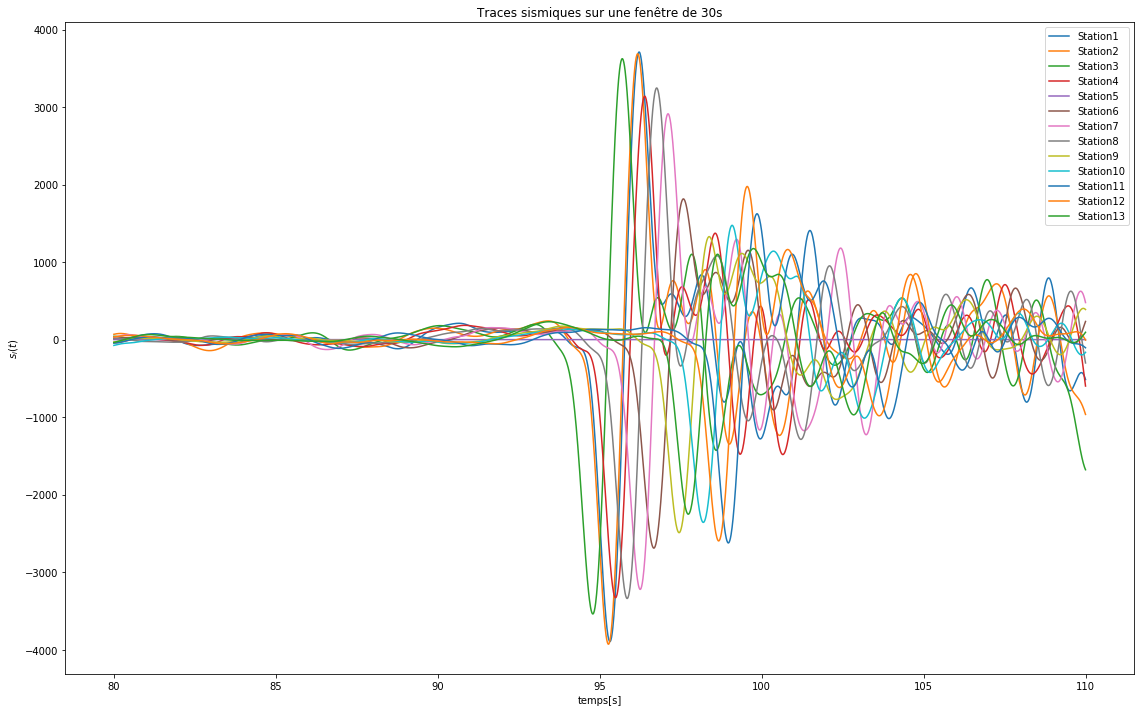

In [8]:
#Extraction de la fenêtre de 30s

X= 30
Fenetre = X*fe
Station_filt30 = [Station_filt[i][8000:8000+Fenetre] for i in range(13) ]

plt.figure(figsize=(16,10))       
for i in range(13) :
     plt.plot(Time[8000:8000+Fenetre],Station_filt30[i], label='Station%d' %(i+1))

plt.xlabel("temps[s]")
plt.ylabel(r"$s_i (t)$")
plt.title("Traces sismiques sur une fenêtre de 30s")
plt.tight_layout()
plt.legend()
plt.show()


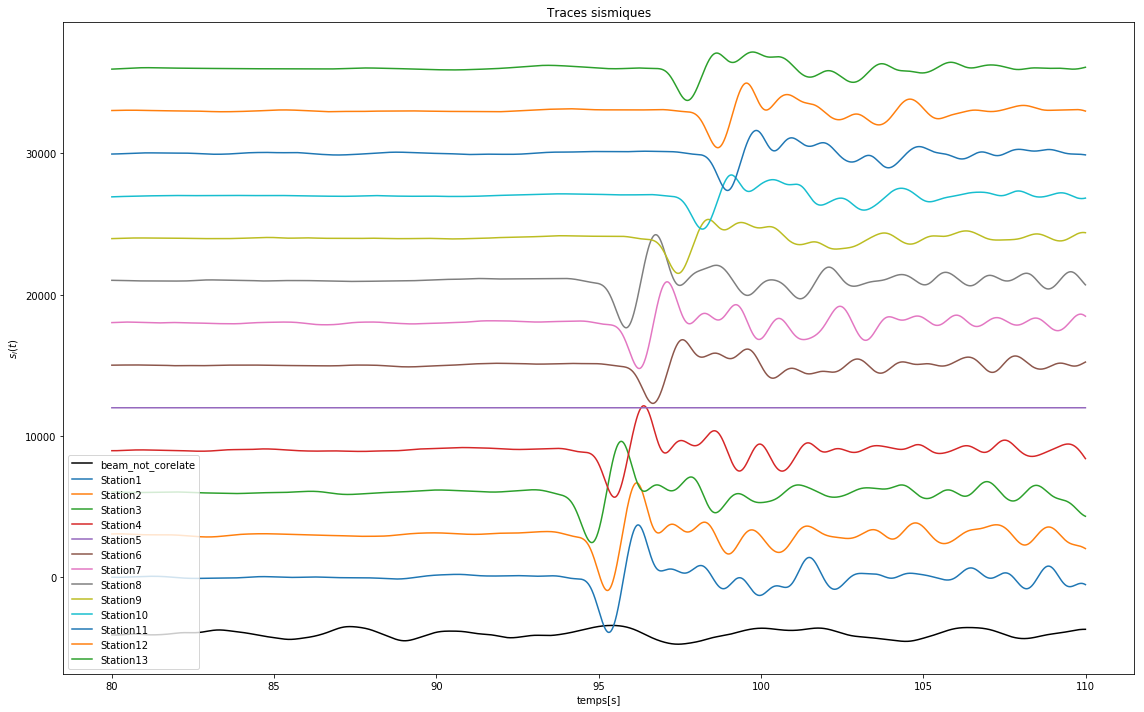

In [9]:
#Representation des traces 


#Sommation sans corrélation


Max_filt=len(Station_filt30[0])
sum_not_corelate = np.zeros(Max_filt)

for i in range(Max_filt) :
    for j in range(13) :
        sum_not_corelate[i] = sum_not_corelate[i] + Station_filt[j][i]
        
plt.figure(figsize=(16,10))
plt.plot(Time[8000:8000+Fenetre], sum_not_corelate -4000, label='beam_not_corelate', color='k')
for i in range(13) :
     plt.plot(Time[8000:8000+Fenetre],Station_filt30[i] + 3000*i, label='Station%d' %(i+1))

        
# On a effectué une translation suivant les amplitudes afin de mieux distinguer les signaux


plt.xlabel("temps[s]")
plt.ylabel(r"$s_i (t)$")
plt.title("Traces sismiques")
plt.tight_layout()
plt.legend()
plt.show()


###### 3.2.2 Choix de la station la plus centrée et calcul des délais

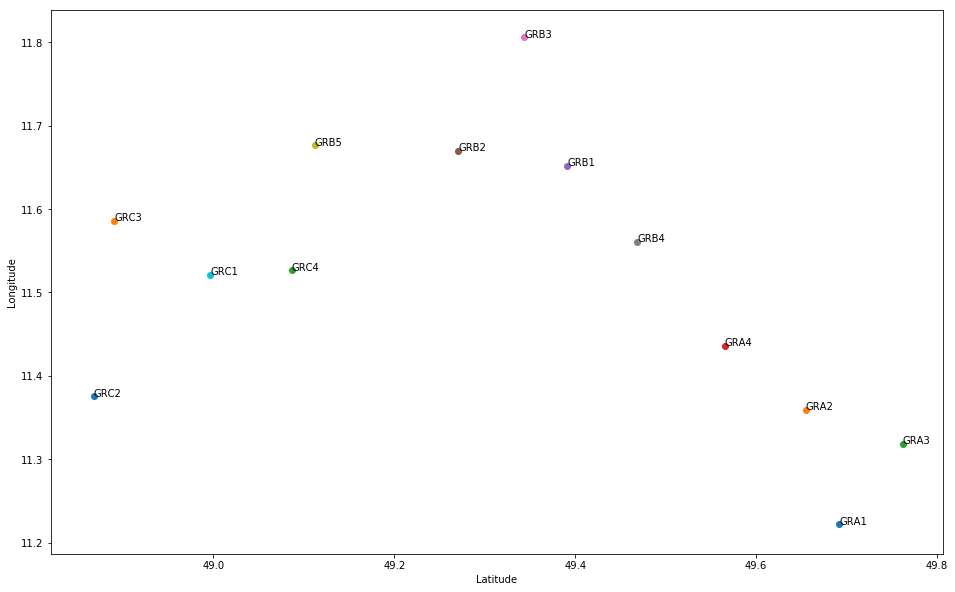

In [41]:
#Détermination de la station la plus centrée

file = open("stations_GR.dat", "r") #Ouverture du fichier contenant les données de positionnement des stations
Coordinates = file.readlines()      #Lecture des données de Longitude et Latitude

for i in range(len(Coordinates)) :
    Coordinates[i] = Coordinates[i].split()
    Coordinates[i][2] = float(Coordinates[i][2])
    Coordinates[i][3] = float(Coordinates[i][3])

#Représentation spatiale du réseau


plt.figure(figsize=(16,10))
for i in range(13):
    plt.scatter(Coordinates[i][2],Coordinates[i][3])
    plt.text(Coordinates[i][2],Coordinates[i][3], Coordinates[i][1]  )            
                
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.show()
                



À partir de ce graphe on peut estimer que la station la plus au centre est la station GRB2

In [11]:
#Calculons les délais 


TAU = np.zeros(13, dtype=int)
for i in range(13) :
    
        corelation_func = np.correlate(Station_filt30[5],Station_filt30[i] , mode='full')

        # Normalisation du coefficient d'auto-corrélation et calcul du retard temporel tau
        corelation_func = corelation_func/np.std(Station_filt30[5])/np.std(Station_filt30[i])/len(Station_filt30[5])
        tau_i = np.argmax(corelation_func)
        TAU[i] = tau_i
        
TAU = TAU - 3000   
TAU_s = TAU/100

/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


###### 3.2.3 Calcul du meilleur beam

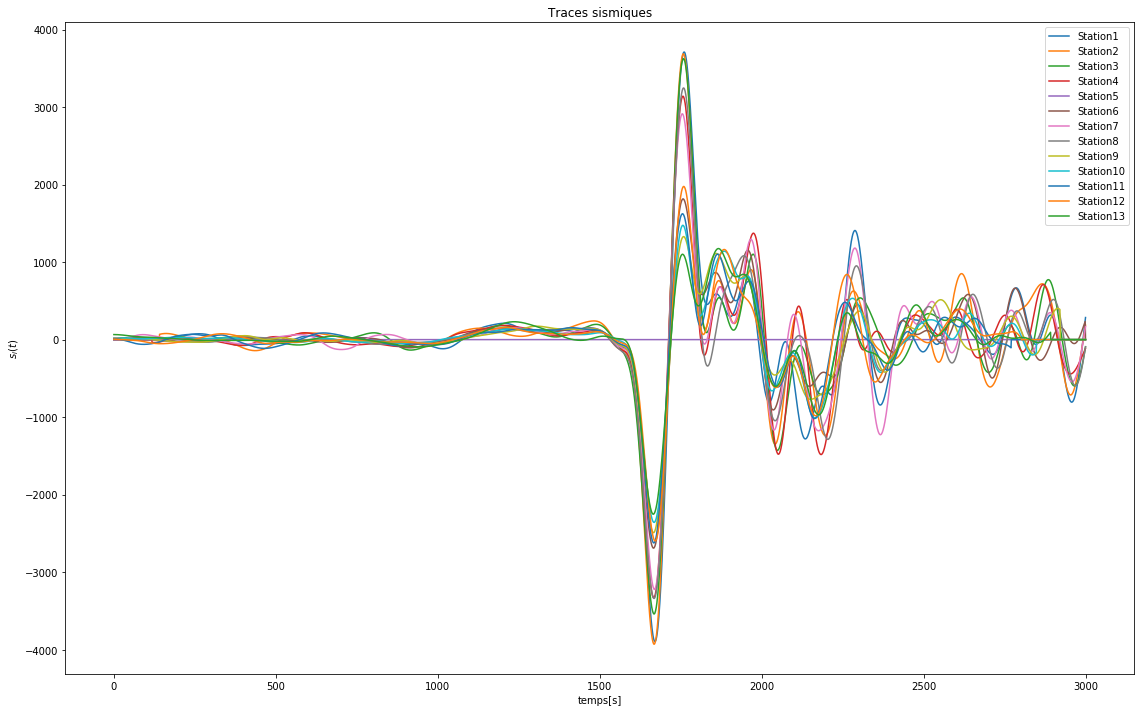

In [12]:
#Définition du Dirac que l'on va décaler intialement à 15s afin de gérer les variations des signes des retards tau_i


def dirac(t) :
    Dirac = np.zeros(3000)
    Dirac[1500+t] = 1

    return Dirac


#Décalage des signaux pour les beams
Station_DCL = []
for i in range(13) :
    Station_decal = np.convolve(Station_filt30[i], dirac(TAU[i]), mode='full')
    Station_DCL.append(Station_decal[1500:4500])
    

#Time[8000:8000+Fenetre] Fenêtre de 30 seconde autour des premières arrivées

plt.figure(figsize=(16,10))
for i in range(13) :
     plt.plot(Station_DCL[i], label='Station%d' %(i+1))

plt.xlabel("temps[s]")
plt.ylabel(r"$s_i (t)$")
plt.title("Traces sismiques")
plt.tight_layout()
plt.legend()
plt.show()

Représentation de beam et des traces correlées

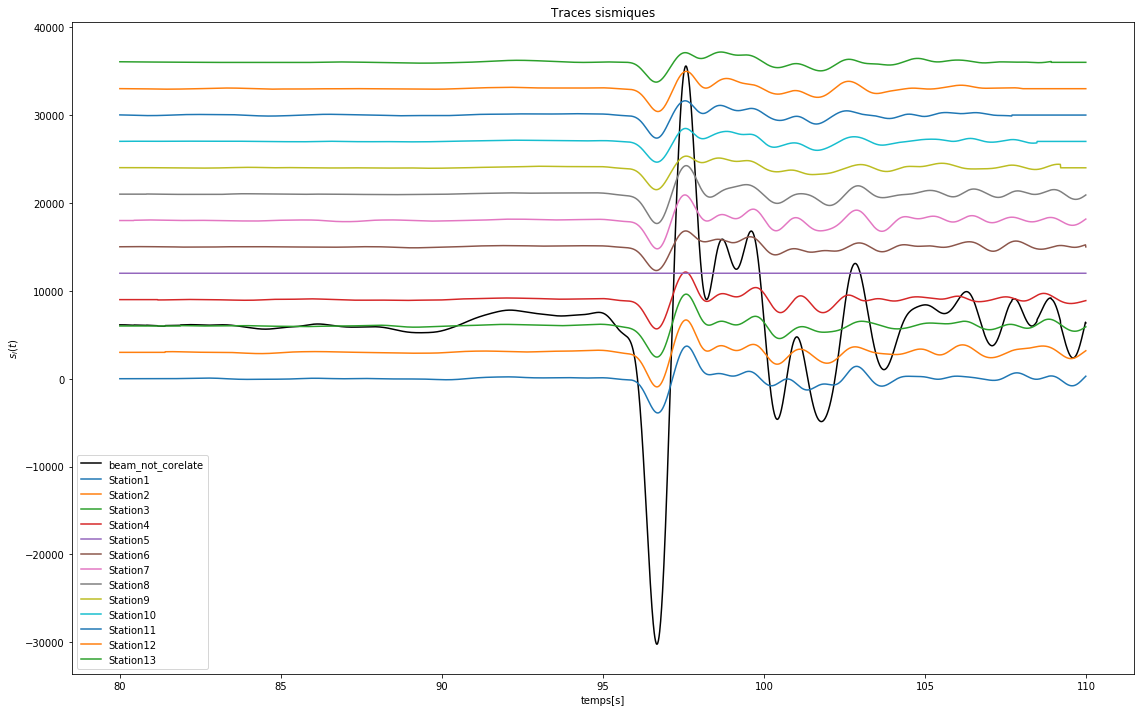

In [13]:
beam = np.zeros(Max_filt)
for i in range(Max_filt) :
    for j in range(13) :
        beam[i] = beam[i] + Station_DCL[j][i]
        
plt.figure(figsize=(16,10))
plt.plot(Time[8000:8000+Fenetre], beam + 6000, label='beam_not_corelate', color='k')
for i in range(13) :
     plt.plot(Time[8000:8000+Fenetre],Station_DCL[i] + 3000*i, label='Station%d' %(i+1))

plt.xlabel("temps[s]")
plt.ylabel(r"$s_i (t)$")
plt.title("Traces sismiques")
plt.tight_layout()
plt.legend()
plt.show()

on remarque un gain fort en amplitude pour le signal Beam, ce signal beam présente donc un rapport signal sur bruit élévé





3.2.4 Calcul des valeurs de $U_h$ et $\theta$

Pour calculer les valeurs de  $U_h$ et $\theta$ on effectue une régréssion linéaire à partir des valeurs de $\tau_i$ calculées on trouve:

$U_h$ = 6 et $\theta$ = 35°


3.2.5 Cette méthode permet d'obtenir une amplification des signaux cohérents et permet donc de diminuer la contribution du bruit non cohérent.


## 3.3 VESPAGRAMME

###### 3.3.1 Construction et representation des Vespagrammes

In [14]:
#Vecteur Distances
Distance =Coordinates.copy()

x = Coordinates[5][2]          #Coordonnée North de la station centrale
y = Coordinates[5][3]          #Coordonnée East de la Station centrale
for i in range(13) :
    Distance[i][2] = (Distance[i][2] - x)
    Distance[i][3] = (Distance[i][3] - y)
    

vespagramme


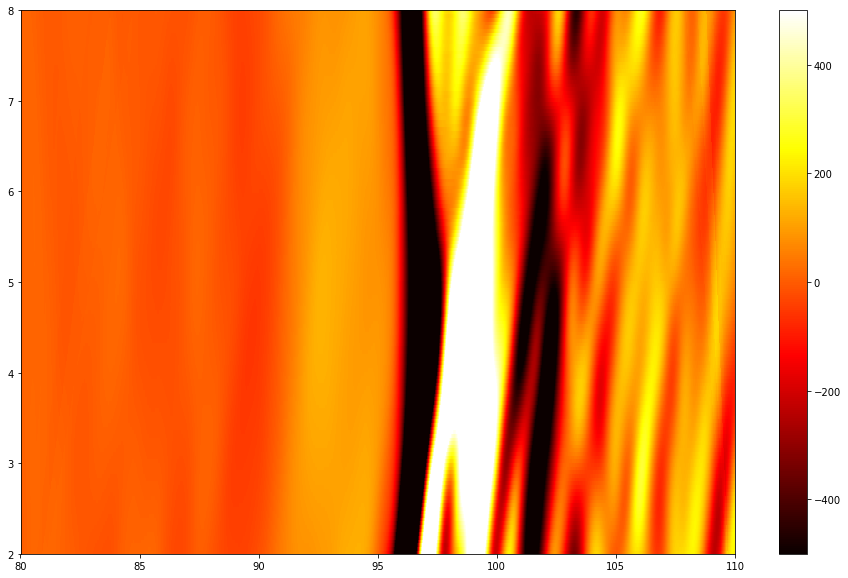

In [15]:
#Vespagramme
theta1= 20.82

#Fonction de décalage

# Shift calcul les reatrds tau_i de chaque station par rapport à la station centrale

def Shift(u,theta) :
    Shift_U = []
    for i in range(13) :
        tau_ui = Distance[i][3]*np.cos(theta)*u + Distance[i][2]*np.sin(theta)*u
        Shift_U.append(int(tau_ui*100))
    return Shift_U

# Décale chaque station à partir de son tau_i correspondant

def Trace_decal(TAU) :
    Trace_DCL = []
    for i in range(13) :
        trace_decal = np.convolve(Station_filt30[i], dirac(TAU[i]), mode='full')
        Trace_DCL.append(trace_decal[1500:4500])
    return Trace_DCL

#Calcul le beam du réseau
def BEAM(T) :
    BEAM = np.zeros(Max_filt) 
        
    for i in range(Max_filt) :
        for j in range(13) :
            BEAM[i] = BEAM[i] + T[j][i]
    
    return BEAM/13

#Programmation du Vespagramme

U = np.linspace(2,8,150) 

VESPA = []
for u in U :
    v = BEAM(Trace_decal(Shift(u,theta1)))
    VESPA.append(v)
    
plt.figure(figsize=(16,10))
plt.pcolormesh(Time[8000:8000+Fenetre],U, VESPA, cmap='hot', vmin=-500, vmax=500)
#plt.contour(Time[8000:8000+Fenetre],U, VESPA)
plt.colorbar()
plt.show()

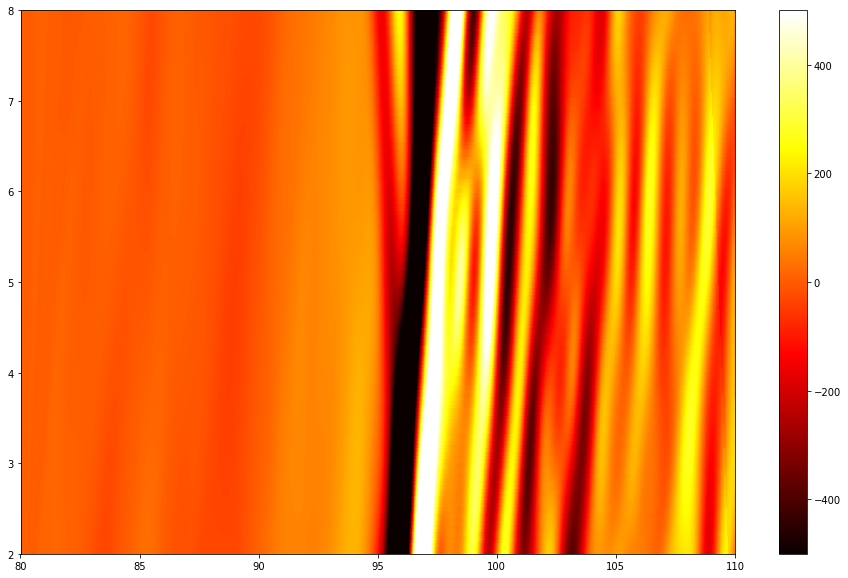

In [16]:
#Vespagramme2
theta2= 22
VESPA = []
for u in U :
    v = BEAM(Trace_decal(Shift(u,theta2)))
    VESPA.append(v)
    #plt.plot(v)
plt.figure(figsize=(16,10))
plt.pcolormesh(Time[8000:8000+Fenetre],U, VESPA, cmap='hot', vmin=-500, vmax=500)
#plt.contour(Time[8000:8000+Fenetre],U, VESPA, colors='grey')
plt.colorbar()
plt.show()

On distingue 3 phases sismiques dans cet exemple 

###### 3.3.4 Avantages et inconvénients de cette technique


Cette technique permet de distinguer les différentes phases sismiques présentent dans un enregistrement d'un réseau de station. l'inconveniant est l'échantillonnage des  vitesses

## 3.4 Sommation en phase (PWS: Phase Weighted Stack)

###### 3.4.1 Calcul de la sommation pondérée

###### 3.4.2 Représentation de la sommation pondérée

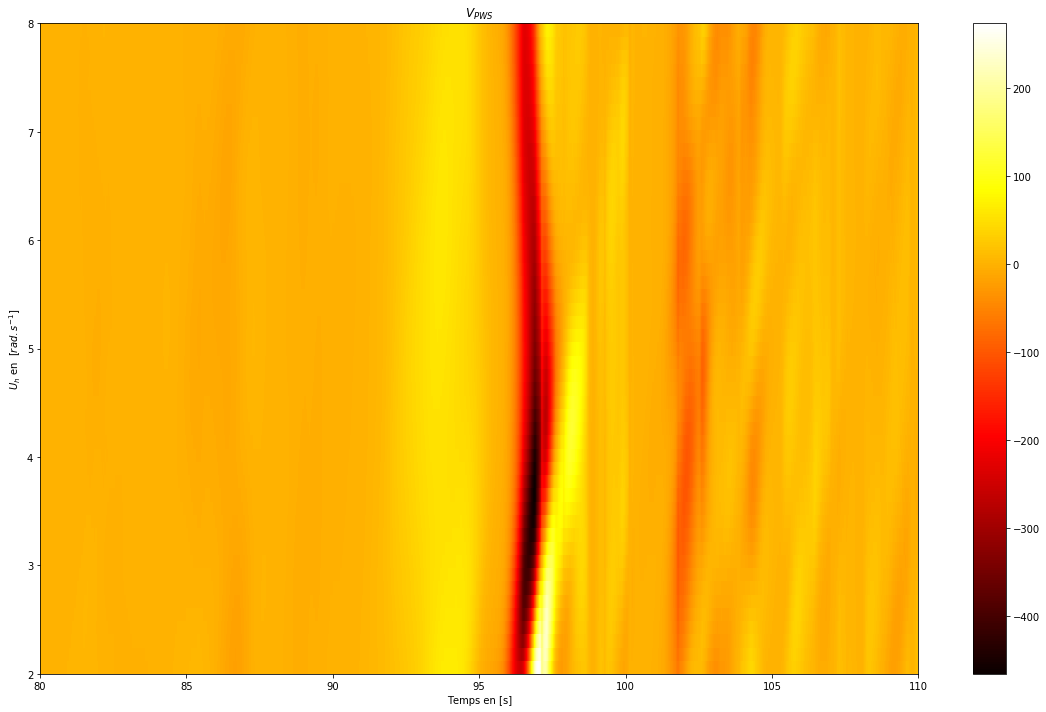

In [17]:
#Vecteur des vitesses horizontales
U = np.linspace(2,8,50)

#Tableau VPWS
VPWS = []
for u in U:
    
    beam_shift = BEAM(Trace_decal(Shift(u,theta1)))              #Calcul d'un beam des traces décalées
    sig = np.zeros(len(Station_filt30[0]), dtype=complex)
    
    #Calcul et sommation pour obtenir la cohérence
    for i in range(13) :
        if i != 4 :
        
        
            Signal_A = signal.hilbert(Station_filt30[i])
            sig += Signal_A/np.abs(Signal_A)
    
    
    sig_abs = (np.abs(sig/13))**2
    beam_shift = beam_shift*sig_abs                  #Calcul du vecteur V_PWS(t)
    VPWS.append(beam_shift)

#Représentation graphique


plt.figure(figsize=(16,10))    
plt.pcolormesh(Time[8000:8000+Fenetre], U, VPWS, cmap='hot')   
plt.colorbar()
plt.xlabel(r"Temps en [s]")
plt.ylabel(r"$U_h$ en  $[rad.s^{-1}]$")
plt.title("$V_{PWS}$")
plt.tight_layout()
plt.show()   

On observe la première arrivée des ondes P qui se distingue beaucoup mieux, et en même temps, on a une diminution des autres arrivées

###### 3.4.3 Limites et avantages de cette technique

## 3.5 Analyse en lenteur et en Azimuth

###### 3.5.1 Définition de la grille de lenteur et de back Azimuth

In [2]:
#Grille de lenteur et back azimuth
U = np.linspace(2,8,30)

THETA = np.linspace(0,360,100)*np.pi/180


###### 3.5.2 Calcul de l'energie

In [48]:
#L'énergie d'un signal beam

def Energie(u, theta,B):
    dt=1/fe
    E=0

    for t in range(int((17-1.5)/dt), int((17+1.5)/dt)):
           E += dt*(B[t]**2+B[t+1]**2)/2
    return E


EN = []               #Vecteur contenant les energies pour des valeurs de u et theta
for u in U :
    Et = np.zeros(len(THETA), dtype=float)
    
    for t in range(len(THETA)) :
        
        sig = BEAM(Trace_decal(Shift(u,THETA[t])))
        Et[t] = Energie(u,THETA[t],sig)
    EN.append(Et)   


###### 3.5.3 Représentation de l'énergie

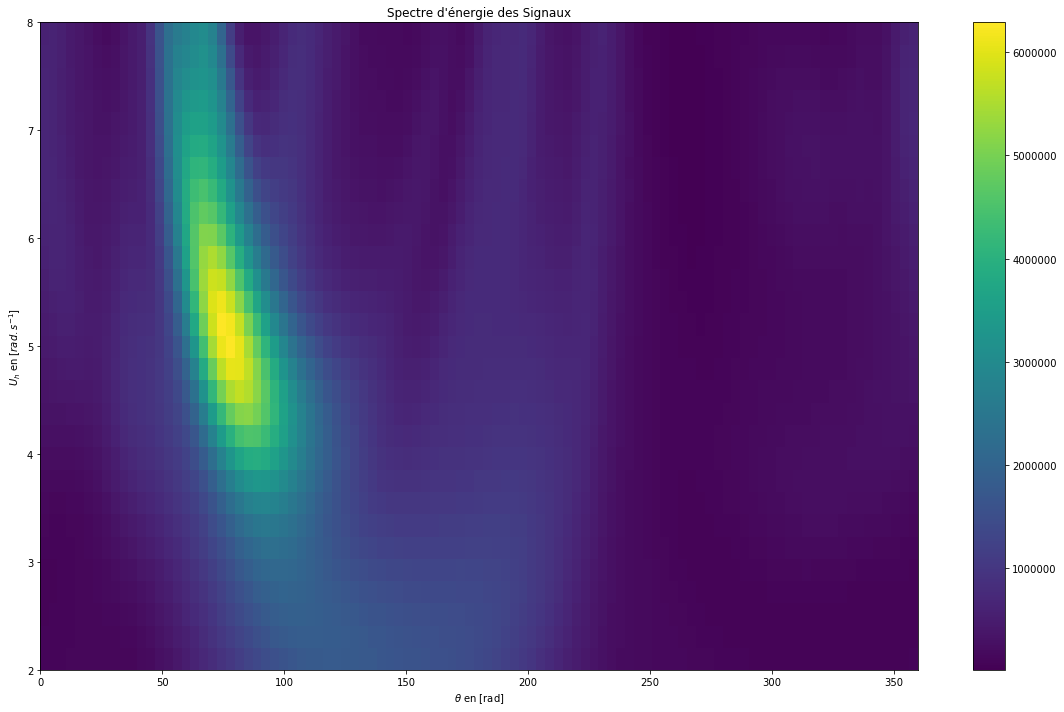

In [57]:
plt.figure(figsize=(16,10))
plt.pcolormesh(THETA*180/np.pi,U, EN)
plt.colorbar()
plt.xlabel(r"$\theta$ en [rad]")
plt.ylabel(r"$U_h$ en $[rad.s^{-1}]$")
plt.title("Spectre d'énergie des Signaux")
plt.tight_layout()
plt.show()


3.5.4 on en déduit des valeurs optimales $U_h$= 5 $rad.s^{-1}$ et $tetha$ = 55° on trouve une valeur de de $tetha$ 2x plus grande.



## 4 Fonction de Transfert de l'antenne

###### 4.1 Définition de la grille en lenteur et en back azimuth

In [23]:
#Grille de lenteur et back azimuth
U1 = np.linspace(2,8,200)

THETA1 = np.linspace(0,360,200)*np.pi/180


#### 4.2 Calcul de la fonction de transfert

In [24]:
#fonction calculant une valeur de A selon la formule

def Transfert(u,theta):
    transfert = 0

    for i in range(13):
        
        c = np.cos(2*np.pi*u*(np.sin(theta)*Distance[i][2] + np.cos(theta)*Distance[i][3])) 
        s = np.sin(2*np.pi*u*(np.sin(theta)*Distance[i][2] + np.cos(theta)*Distance[i][3]))
        
        transfert += complex(c,s)


    return (np.abs(transfert/13))**2

A_k =[]

for u in U1 :
    
    a_k = np.zeros(len(THETA1))
    
    for t in range(len(THETA1)) :
        
        a_k[t]= Transfert(u,THETA1[t])
        
    A_k.append(a_k**0.5)
        

#### 4.3 Représentation de la fonction de transfert

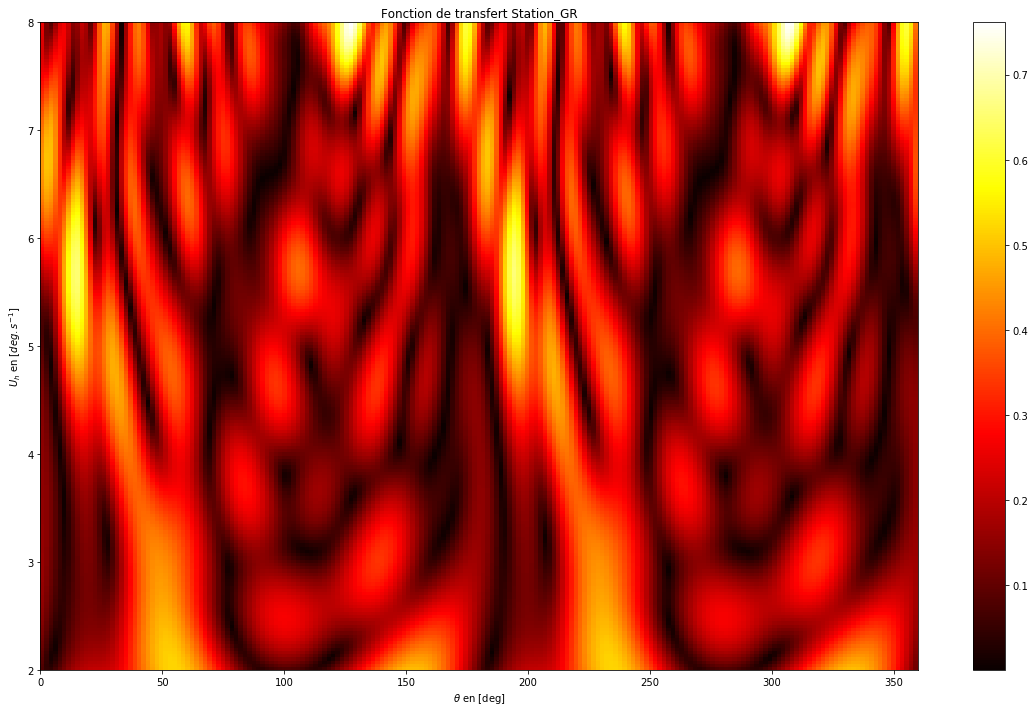

In [26]:
plt.figure(figsize=(16,10))
plt.pcolormesh(THETA1*180/np.pi,U1, A_k, cmap='hot')
plt.colorbar()
plt.xlabel(r"$\theta$ en [deg]")
plt.ylabel(r"$U_h$ en $[deg.s^{-1}]$")
plt.title('Fonction de transfert Station_GR')
plt.tight_layout()
plt.show()

##### 4.4  Station_GE

[['GR', 'GEA0', 48.835994, 13.700943], ['GR', 'GEA1', 48.83551, 13.70295], ['GR', 'GEA2', 48.83781, 13.70092], ['GR', 'GEA3', 48.83422, 13.69901], ['GR', 'GEB1', 48.83811, 13.7065], ['GR', 'GEB2', 48.8387, 13.69765], ['GR', 'GEB3', 48.83618, 13.69491], ['GR', 'GEB4', 48.83204, 13.69785], ['GR', 'GEB5', 48.83382, 13.70501], ['GR', 'GEC1', 48.84045, 13.70891], ['GR', 'GEC2', 48.844303, 13.700627], ['GR', 'GEC3', 48.841561, 13.690754], ['GR', 'GEC4', 48.83432, 13.68669], 'GR GEC5 48.828793 13.694742\n', 'GR GEC6 48.82599 13.70791\n', 'GR GEC7 48.83471 13.713505\n', 'GR GED1 48.8516 13.7138\n', 'GR GED2 48.8526 13.69518\n', 'GR GED3 48.84568 13.68086\n', 'GR GED4 48.837773 13.678704\n', 'GR GED5 48.82379 13.67969\n', 'GR GED6 48.81877 13.69562\n', 'GR GED7 48.819997 13.715016\n', 'GR GED8 48.83234 13.72505\n', 'GR GED9 48.84261 13.722265\n']


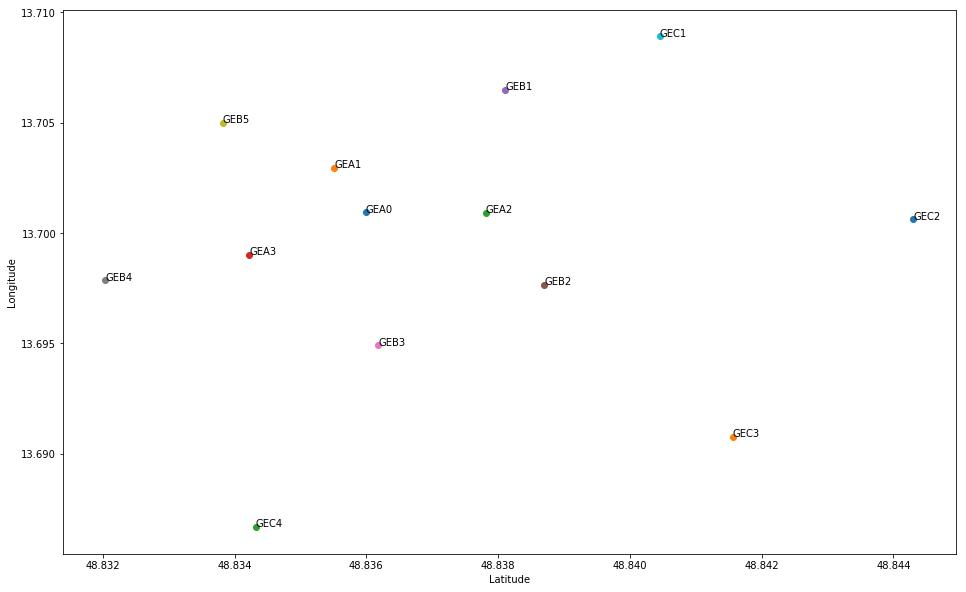

In [42]:
file = open("stations_GE.dat", "r") #Ouverture du fichier contenant les données de positionnement des stations
Coordinates1 = file.readlines()      #Lecture des données de Longitude et Latitude

for i in range(len(Coordinates)) :
    Coordinates1[i] = Coordinates1[i].split()
    Coordinates1[i][2] = float(Coordinates1[i][2])
    Coordinates1[i][3] = float(Coordinates1[i][3])

#Représentation spatiale du réseau

print(Coordinates1)
plt.figure(figsize=(16,10))
for i in range(13):
    plt.scatter(Coordinates1[i][2],Coordinates1[i][3])
    plt.text(Coordinates1[i][2],Coordinates1[i][3], Coordinates1[i][1]  )            
                
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.show()
                

graphiquement la station la plus centrée est GEA2

In [35]:
#centralisation des stations

Distance1 =Coordinates1.copy()

x1 = Coordinates1[2][2]          #Coordonnée North de la station centrale
y1 = Coordinates1[2][3]          #Coordonnée East de la Station centrale
for i in range(13) :
    Distance1[i][2] = (Distance1[i][2] - x1)
    Distance1[i][3] = (Distance1[i][3] - y1)
    

In [36]:
def Transfert1(u,theta):
    transfert = 0

    for i in range(13):
        
        c = np.cos(2*np.pi*u*(np.sin(theta)*Distance1[i][2] + np.cos(theta)*Distance1[i][3])) 
        s = np.sin(2*np.pi*u*(np.sin(theta)*Distance1[i][2] + np.cos(theta)*Distance1[i][3]))
        
        transfert += complex(c,s)


    return (np.abs(transfert/13))**2

A_k1 =[]

for u in U1 :
    
    a_k = np.zeros(len(THETA1))
    
    for t in range(len(THETA1)) :
        
        a_k[t]= Transfert1(u,THETA1[t])
        
    A_k1.append(a_k**0.5)
        

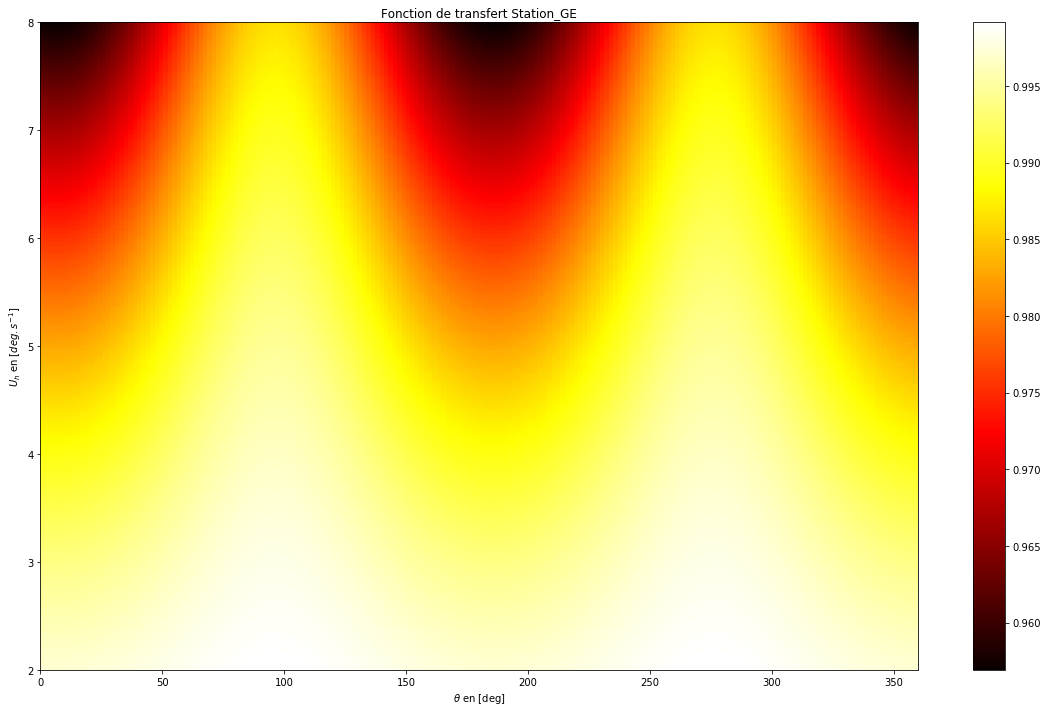

In [37]:
plt.figure(figsize=(16,10))
plt.pcolormesh(THETA1*180/np.pi,U1, A_k1, cmap='hot')
plt.colorbar()
plt.xlabel(r"$\theta$ en [deg]")
plt.ylabel(r"$U_h$ en $[deg.s^{-1}]$")
plt.title('Fonction de transfert Station_GE')
plt.tight_layout()
plt.show()

on voit une très belle fonction de transfert de la station GE on arrive mieux à distinguer l'azimuth avec le réseau GE

### Représentation des deux réseaux

/usr/lib/python3/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


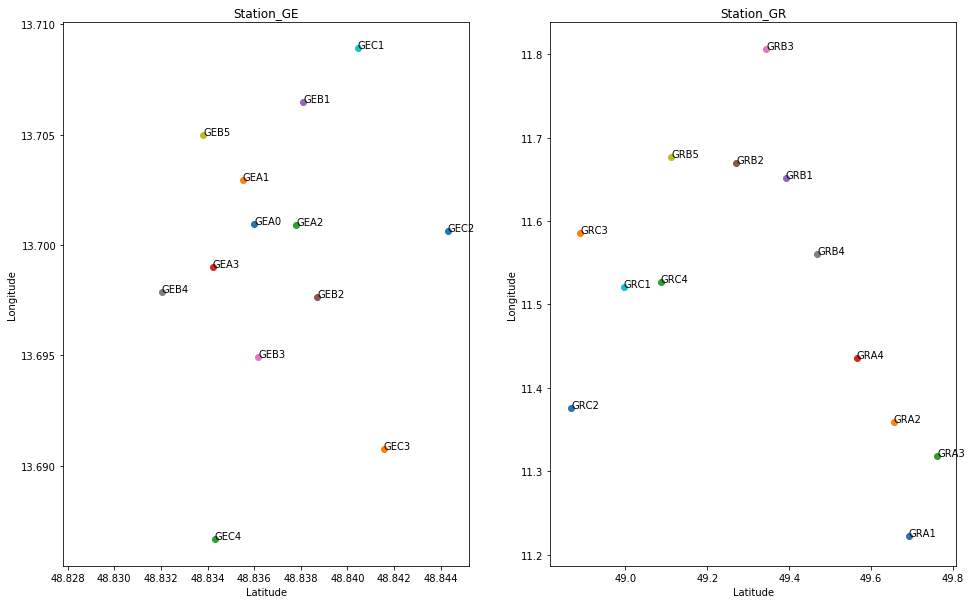

In [47]:
plt.figure(figsize=(16,10)) 
for i in range(13):
    plt.subplot(1,2,1)
    plt.title("Station_GE")
    plt.scatter(Coordinates1[i][2],Coordinates1[i][3])
    plt.text(Coordinates1[i][2],Coordinates1[i][3], Coordinates1[i][1]  )            
    plt.xlabel("Latitude")
    plt.ylabel("Longitude")
    
    
    
    plt.subplot(1,2,2)
    plt.title("Station_GR")
    plt.scatter(Coordinates[i][2],Coordinates[i][3])
    plt.text(Coordinates[i][2],Coordinates[i][3], Coordinates[i][1]  )            
    plt.xlabel("Latitude")
    plt.ylabel("Longitude")          

plt.tight_layout

plt.show()

on constate que la géométrie des station est différente. On peut donc conclure que la géométrie du réseau est un facteur éssentielle afin d'avoir une bonne antenne